In [1]:
import time
from tqdm import tqdm
from utils import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

sns.set_theme(style="white")

from sklearn import manifold, cluster, metrics
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from keras.applications.vgg16 import VGG16
from keras import Model
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

# from PIL import Image
# Image.MAX_IMAGE_PIXELS = int(1e9) # increase maximum size of loaded images

import cv2

# Traitement des images avec SIFT

In [2]:
def imshow(image, cmap="gray"):
    plt.imshow(image, cmap=cmap)
    plt.axis("off")

## Préparation des données

### Création du dataset

In [3]:
# import des données
df = pd.read_csv("data/flipkart_com-ecommerce_sample_1050.csv")
df_text = pd.read_csv("data/df_text.csv", index_col=0)

categories = list(df_text["category"].unique())  # liste des catégories
n_labels = len(categories)  # nombre de catégories

# encodage des catégories
cat_labels = df_text["category"].apply(lambda x: categories.index(x)).values

# création du DataFrame pour traiter les images
df_images = pd.DataFrame(
    {
        "image_path": df["image"].map(lambda x: f"./data/images/{x}"),
        "category": df_text["category"],
        "label": cat_labels,
    }
)
df_images.to_csv("data/df_images.csv")
df_images.head()

,image_path,category,label
0,./data/images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing,0
1,./data/images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care,1
2,./data/images/64d5d4a258243731dc7bbb1eef49ad74...,Baby Care,1
3,./data/images/d4684dcdc759dd9cdf41504698d737d8...,Home Furnishing,0
4,./data/images/6325b6870c54cd47be6ebfbffa620ec7...,Home Furnishing,0


### Affichage d'exemples d'images

                           Home Furnishing                            


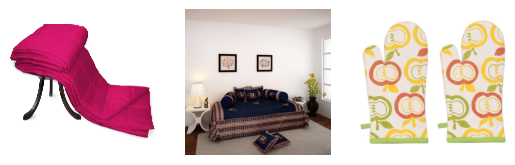

                              Baby Care                               


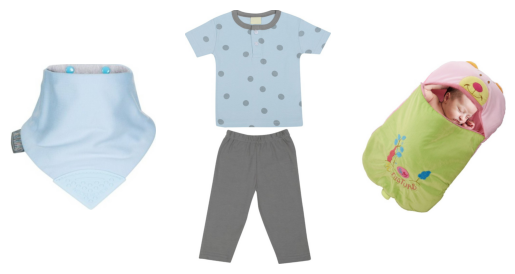

                               Watches                                


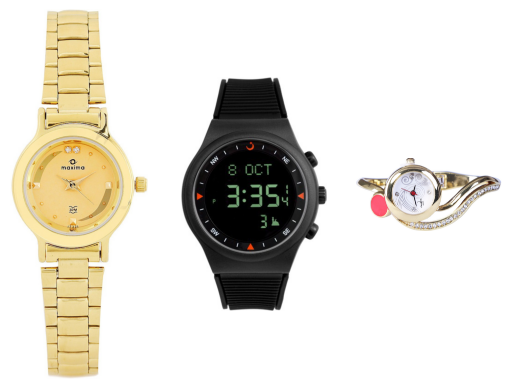

                      Home Decor & Festive Needs                      


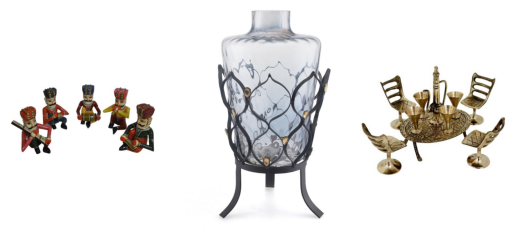

                           Kitchen & Dining                           


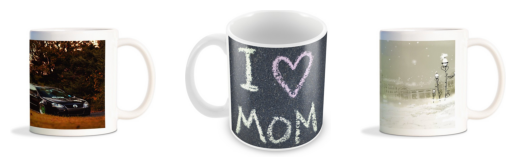

                       Beauty and Personal Care                       


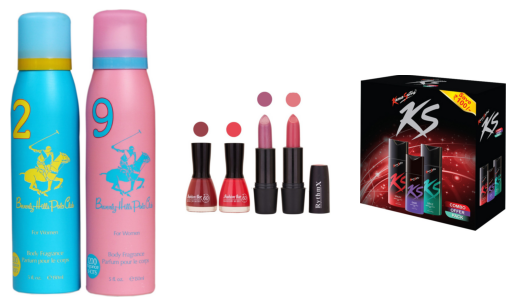

                              Computers                               


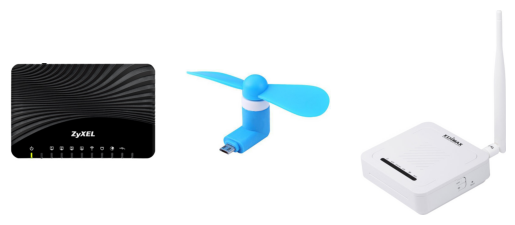

In [4]:
# On va afficher 3 images par catégories
for cat in categories:
    print(cat.center(70))
    paths = list(
        df_images.loc[df_images["category"] == cat, "image_path"].sample(
            3, random_state=3
        )
    )
    for i in range(3):
        plt.subplot(130 + 1 + i)
        image = imread(paths[i])
        imshow(image)
    plt.show()

## Détermination et affichage des descripteurs SIFT

### Exemple sur une image

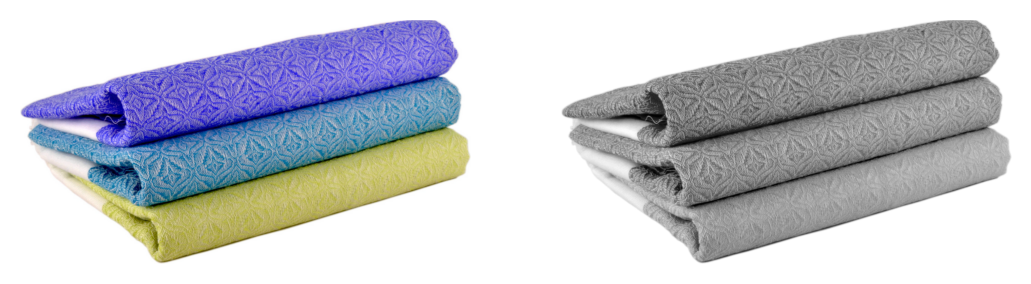

In [5]:
image = cv2.imread(df_images["image_path"].iloc[1], 1)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.figure(dpi=200)
plt.subplot(121)
imshow(image)
plt.subplot(122)
imshow(gray)

In [6]:
# convert back to rgb-scale for upcoming plots
gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
gray_rgb.shape

(1293, 2388, 3)

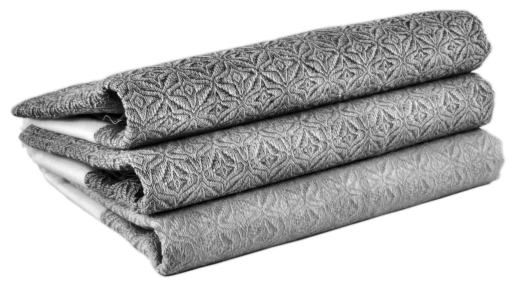

In [7]:
# Let's improve the contrast using Contrast Limited Adaptive Histogram Equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
cl_image = clahe.apply(gray)
imshow(cl_image)

In [8]:
# Detect keypoint features with SIFT
sift = cv2.SIFT_create()
kp = sift.detect(cl_image, None)
len(kp)

52368

Il y a énormément de keypoints. Regardons le nombre de keypoints qu'on obtient sur l'image initiale :

In [9]:
# Detect keypoint features with SIFT
kp = sift.detect(gray, None)
len(kp)

25445

Il en reste encore beaucoup trop. Floutons l'image pour réduire le nombre de keypoints :

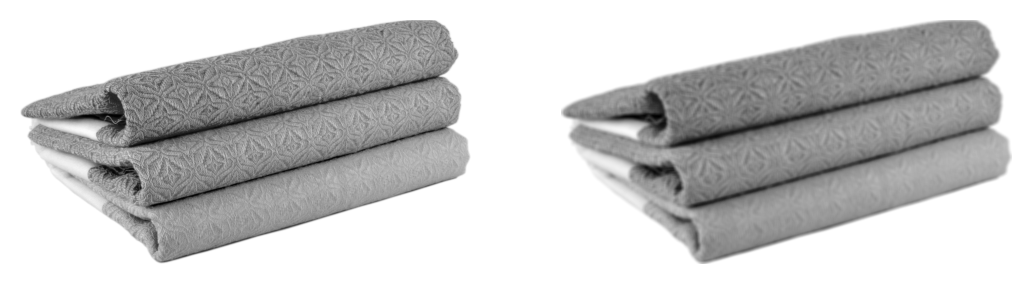

In [10]:
kernel = (20, 20)
blured = cv2.blur(gray, kernel)
plt.figure(dpi=200)
plt.subplot(121)
imshow(gray)
plt.subplot(122)
imshow(blured)

In [11]:
sift = cv2.SIFT_create()
kp = sift.detect(blured, None)
len(kp)

155

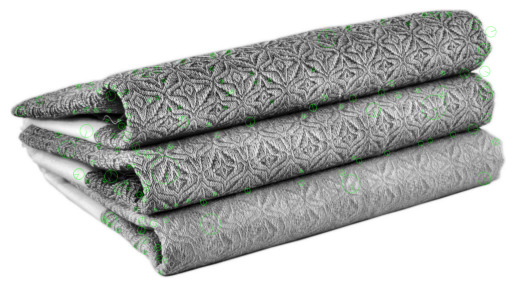

In [12]:
# kp, des = sift.detectAndCompute(blured, None)
img = cv2.drawKeypoints(
    cl_image,
    kp,
    cl_image,
    color=(0, 255, 0),
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
)
imshow(img)

On ne voit pas grand chose avec la fonction `drawKeypoints` de OpenCV.
Construisons notre propre fonction pour mieux visualiser les keypoints :

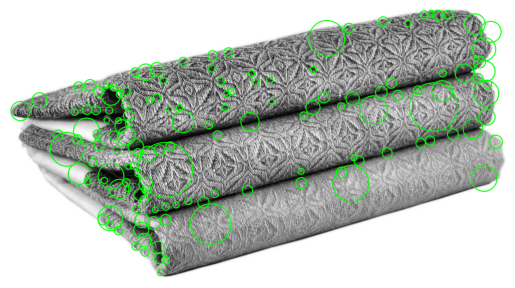

In [13]:
def drawKeypoints(image, keypoints, color=(0, 255, 0), thickness=3):
    img = image.copy()
    for keypoint in keypoints:
        x = np.uint16(keypoint.pt[0])
        y = np.uint16(keypoint.pt[1])
        size = np.uint16(keypoint.size)
        cv2.circle(img, (x, y), size, color, thickness=thickness, lineType=8, shift=0)
    imshow(img)
    # return image


cl_rgb = cv2.cvtColor(cl_image, cv2.COLOR_GRAY2RGB)
drawKeypoints(cl_rgb, kp, (0, 255, 0), 3)

### Applications sur plusieurs images

Appliquons les opérations précédentes sur plusieurs images et visualisons les résultats.

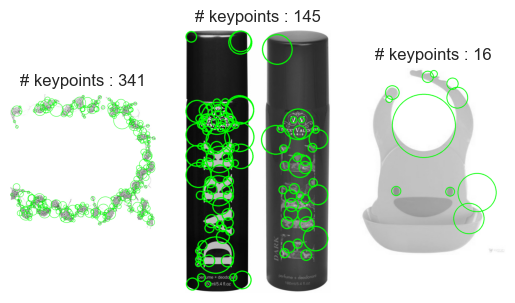

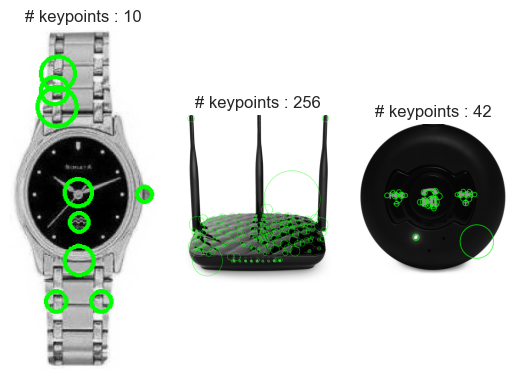

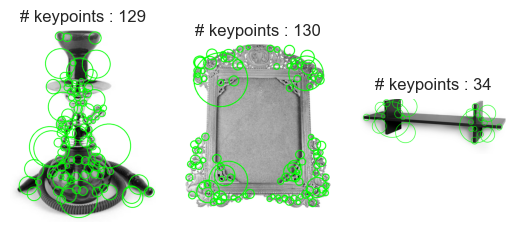

In [14]:
sift = cv2.SIFT_create()
blur_kernel = (20, 20)
i = 0
for path in df_images["image_path"].sample(9, random_state=9):
    if i % 3 == 0:
        plt.figure()
    gray = cv2.imread(path, 0)
    gray_rgb = cv2.cvtColor(gray, cv2.COLOR_GRAY2RGB)
    gray_rgb.shape
    blured = cv2.blur(gray, blur_kernel)
    keypoints = sift.detect(blured, None)
    plt.subplot(130 + (i % 3) + 1)
    plt.title(f"# keypoints : {len(keypoints)}")
    drawKeypoints(gray_rgb, keypoints, (0, 255, 0), 3)
    i += 1

## Extraction des descripteurs de toutes les images

### Créations des descripteurs de chaque image
* création d'une liste de descripteurs par image (``sift_descriptors_by_img``) qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images (``sift_descriptors_all``) qui sera utilisé pour créer les clusters de descripteurs

In [15]:
# cell to stop the run
error

In [16]:
%%time
sift_descriptors = []
sift = cv2.SIFT_create(100)  # maximum of 100 keypoints
blur_kernel = (20, 20)
for i in tqdm(range(df_images.shape[0])):
    gray = cv2.imread(df_images["image_path"].iloc[i], 0)  # import image in grayscale
    blured = cv2.blur(gray, blur_kernel)
    kp, des = sift.detectAndCompute(blured, None)
    sift_descriptors.append(des)

100%|██████████| 1050/1050 [08:45<00:00,  2.00it/s] 

CPU times: total: 13min 35s
Wall time: 8min 45s


On va transformer la liste ``sift_descriptors`` en tableau numpy puis on va concaténer tous les éléments dans l'objet ``sift_descriptors_all``

In [17]:
sift_descriptors_by_img = np.asarray(sift_descriptors, dtype="object")
sift_descriptors_by_img.shape

(1050,)

In [18]:
sift_descriptors_all = np.concatenate(sift_descriptors_by_img, axis=0)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 343 has 0 dimension(s)

On rencontre une erreur car l'élément se trouvant à l'index 343 est vide, cela signifie que l'algorithme SIFT n'a détecté aucun keypoints. Regardons cela de plus près.

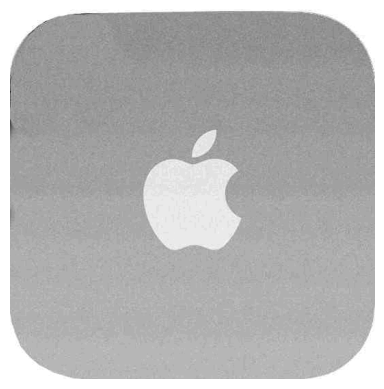

In [19]:
# Let's take a look at the image in question
index = 343
gray = cv2.imread(df_images["image_path"].iloc[index], 0)
imshow(gray)

In [20]:
gray.min(), gray.max()

(220, 255)

Let's increase the contrast by equalizing the image histogram and see if we can detect keypoints on the new image.

100

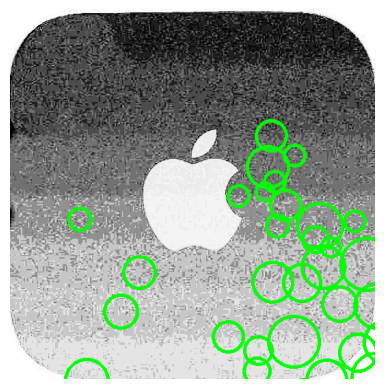

In [21]:
equ = cv2.equalizeHist(np.uint8(gray))
keypoints = sift.detect(equ, None)
equ_rgb = cv2.cvtColor(equ, cv2.COLOR_GRAY2RGB)
drawKeypoints(equ_rgb, kp, (0, 255, 0), 3)
len(kp)

Let's insert the image descriptors in ``sift_descriptors``.

In [22]:
kp, des = sift.compute(equ, keypoints)
sift_descriptors[index] = des
sift_descriptors[index].shape

(100, 128)

In [23]:
sift_descriptors_by_img = np.asarray(sift_descriptors, dtype="object")
sift_descriptors_by_img.shape

(1050,)

In [24]:
sift_descriptors_all = np.concatenate(sift_descriptors_by_img, axis=0)
sift_descriptors_all.shape

(80828, 128)

There is a total of **80 828** descriptors across all images. Let's save them using ``pickle`` :

In [25]:
# # Save descriptors
# import pickle
# with open('data/sift_descriptors', 'wb') as fichier:
#     my_pickler = pickle.Pickler(fichier)
#     my_pickler.dump(sift_descriptors_by_img)

In [26]:
# # load descriptors
# import pickle
# with open('data/sift_descriptors', 'rb') as fichier:
#     my_unpickler = pickle.Unpickler(fichier)
#     sift_descriptors_by_img = my_unpickler.load()
# sift_descriptors_all = np.concatenate(sift_descriptors_by_img, axis=0)

### Création des clusters de descripteurs

On va regrouper les descripteurs en clusters à l'aide d'un algorithme de clustering.
Nous allons utiliser ``MiniBatchKMeans`` pour obtenir des temps de traitement raisonnables.

In [27]:
start = time.time()

k = round(np.sqrt(len(sift_descriptors_all)))
print("Nombre de clusters estimés :", k)

# Clustering
print(f"Création de {k} clusters de descripteurs ...")
kmeans = cluster.MiniBatchKMeans(n_clusters=k, random_state=0)
kmeans.fit(sift_descriptors_all)

end = time.time()
print("temps de traitement kmeans : %.2f secondes" % (end - start))

Nombre de clusters estimés : 284
Création de 284 clusters de descripteurs ...


c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


temps de traitement kmeans : 2.79 secondes


### Création des features des images

Pour chaque image, nous allons déterminer le cluster de chaque descripteur puis construire un histogramme représentant le nombre de descripteurs par cluster.

Nous considérerons les features d'une image comme étant l'histogramme correspondant à cette image, c'est-à-dire le nombre de descripteurs par cluster.

In [28]:
def build_histogram(kmeans, des, image_num):
    labels = kmeans.predict(des)
    hist = np.zeros(k)
    nb_des = len(des)  # or des.shape[0]
    if nb_des == 0:
        print("problème : pas de descripteur pour l'image :", image_num)
    for i in labels:
        hist[i] += 1.0 / nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors = []

# Creation of histograms (features)
start = time.time()
for i, image_desc in enumerate(sift_descriptors_by_img):
    # if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calculates the histogram
    hist_vectors.append(hist)  # the histogram is the feature vector
im_features = np.asarray(hist_vectors)

end = time.time()
print("temps de création des histogrammes : %.2f secondes" % (end - start))
print("Dimensions de la matrices des histogrammes :", im_features.shape)

temps de création des histogrammes : 0.29 secondes
Dimensions de la matrices des histogrammes : (1050, 284)


### Réduction de dimension

#### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé
* L'impact est une meilleure séparation des données et une réduction du temps de traitement du t-SNE

In [29]:
print("Dimensions dataset avant réduction PCA :", im_features.shape)
pca = PCA(n_components=0.95)
feat_pca = pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA :", feat_pca.shape)

Dimensions dataset avant réduction PCA : (1050, 284)
Dimensions dataset après réduction PCA : (1050, 191)


#### Réduction de dimension t-SNE

Réduction de dimension en 2 composantes t-SNE pour afficher les clusters en 2D

In [30]:
tsne = manifold.TSNE(
    n_components=2, perplexity=30, n_iter=1000, init="random", random_state=6
)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=["X_tsne1", "X_tsne2"])
df_tsne["class"] = df_images["category"]
df_tsne.head()

,X_tsne1,X_tsne2,class
0,5.727871,21.784243,Home Furnishing
1,20.195164,18.474737,Baby Care
2,23.958656,1.691640,Baby Care
3,-7.960743,19.015556,Home Furnishing
4,5.948412,-1.604988,Home Furnishing


### Analyse visuelle : affichage t-SNE selon les catégories d'images

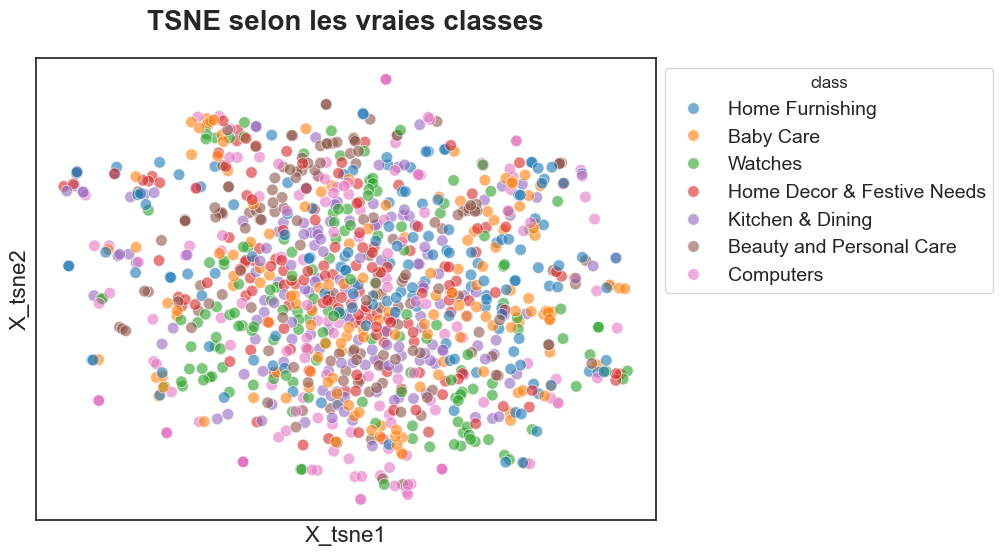

In [31]:
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    x="X_tsne1",
    y="X_tsne2",
    hue="class",
    data=df_tsne,
    legend="auto",
    palette=sns.color_palette("tab10", n_colors=n_labels),
    s=70,
    alpha=0.6,
)

ax.set_title(
    "TSNE selon les vraies classes",
    fontsize=20,
    pad=35,
    fontweight="bold",
    verticalalignment="top",
)
ax.set_xlabel("X_tsne1", fontsize=16, fontweight="normal")
ax.set_ylabel("X_tsne2", fontsize=16, fontweight="normal")
# ax.legend(prop={'size': 14})
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), prop={"size": 14})
ax.set_xticks([])
ax.set_yticks([])
# plt.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False)

plt.show()

Toutes les catégories sont mélangées, on ne voit pas grand chose...

### Mesure de similarité entre catégories et clusters

In [34]:
ARI, X_tsne, labels = ARI_fct(feat_pca, n_labels, cat_labels)

ARI :  0.02 duration :  9.6 s


Comme on pouvait s'y attendre, l'ARI est très mauvais. C'est dû au fait que les catégories ne sont pas séparées

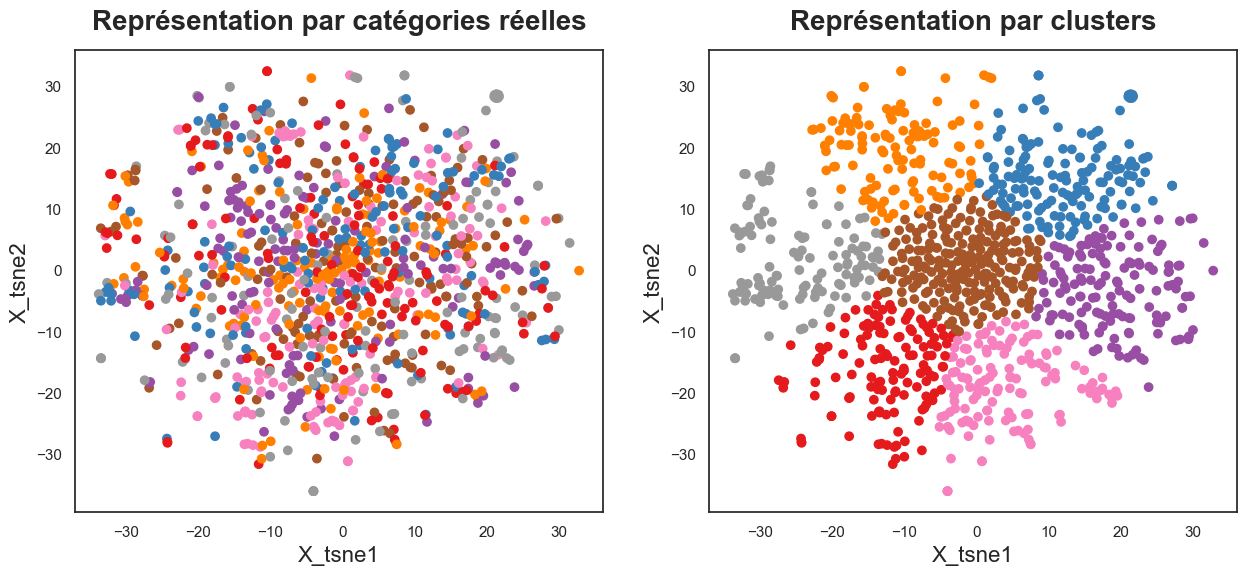

ARI :  0.02


In [35]:
TSNE_visu_fct(
    X_tsne,
    cat_labels,
    labels,
    categories,
    ARI,
    legend_loc="upper left",
    show_ticks=True,
    legend=False,
)

# Transfer Learning avec Keras

On va utiliser le modèle VGG-16 fourni par Keras et pré-entraîné sur ImageNet en enlevant la dernière couche, celle qui sert à faire la classification.

In [36]:
# On charge le modèle VGG-16 pré-entraîné sur ImageNet
model = VGG16()

# On enlève la dernière couche
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Import des images

In [37]:
df_images = pd.read_csv("data/df_images.csv", index_col=0)
display(df_images.head())

,image_path,category,label
0,./data/images/55b85ea15a1536d46b7190ad6fff8ce7...,Home Furnishing,0
1,./data/images/7b72c92c2f6c40268628ec5f14c6d590...,Baby Care,1
2,./data/images/64d5d4a258243731dc7bbb1eef49ad74...,Baby Care,1
3,./data/images/d4684dcdc759dd9cdf41504698d737d8...,Home Furnishing,0
4,./data/images/6325b6870c54cd47be6ebfbffa620ec7...,Home Furnishing,0


Nous devons d'abord charger les images et les pré-traiter afin qu'elles respectent bien les spécifications des images en entrée de VGG-16.
Pour cela, nous allons utiliser les fonctions du module `keras.utils` et `keras.preprocessing.vgg16` :
1. VGG-16 reçoit des images de taille (224, 224, 3) : la fonction `load_img` permet de charger l'image et de la redimensionner correctement
2. Keras traite les images comme des tableaux numpy : `img_to_array` permet de convertir l'image chargée en tableau numpy
3. Le réseau doit recevoir en entrée une collection d'images, stockée dans un tableau à 4 dimensions, où les dimensions correspondent (dans l'ordre) à (nombre d'images, largeur, hauteur, profondeur).
4. Enfin, `preprocess_input` permet d'appliquer les mêmes pré-traitements que ceux utilisés lors du pré-entraînement.

Ainsi, on prépare l'image comme ci-dessous :

In [38]:
images = []
for path in df_images["image_path"]:
    img = load_img(path, target_size=(224, 224))  # charge l'image
    img = img_to_array(img)  # convertit en tableau numpy
    images.append(img)
images = np.array(images)

# Prétraitement de l'image comme le veut VGG-16
images = preprocess_input(images)
images.shape

c:\Users\gabriel.chehade\Documents\Projets\Github\Item-Classification\.venv\Lib\site-packages\PIL\Image.py:3186: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)

In [39]:
# Extraction des features
features = model.predict(images)
features.shape

33/33 [==============================] - 126s 4s/step


(1050, 4096)

## Réduction de dimension

### Réduction de dimension PCA

In [40]:
print("Dimensions dataset avant réduction PCA :", features.shape)
pca = PCA(n_components=0.99)
feat_pca = pca.fit_transform(features)
print("Dimensions dataset après réduction PCA :", feat_pca.shape)

Dimensions dataset avant réduction PCA : (1050, 4096)
Dimensions dataset après réduction PCA : (1050, 803)


### Réduction de dimension t-SNE

Réduction de dimension en 2 composantes t-SNE pour affichage en 2D des images

In [41]:
ARI, X_tsne, cls_labels = ARI_fct(feat_pca, n_labels, cat_labels)

ARI :  0.49 duration :  8.4 s


In [42]:
# On échange les numéro de certains clusters pour mieux comparer visuellement
switch(cls_labels, 1, 6)
switch(cls_labels, 2, 4)

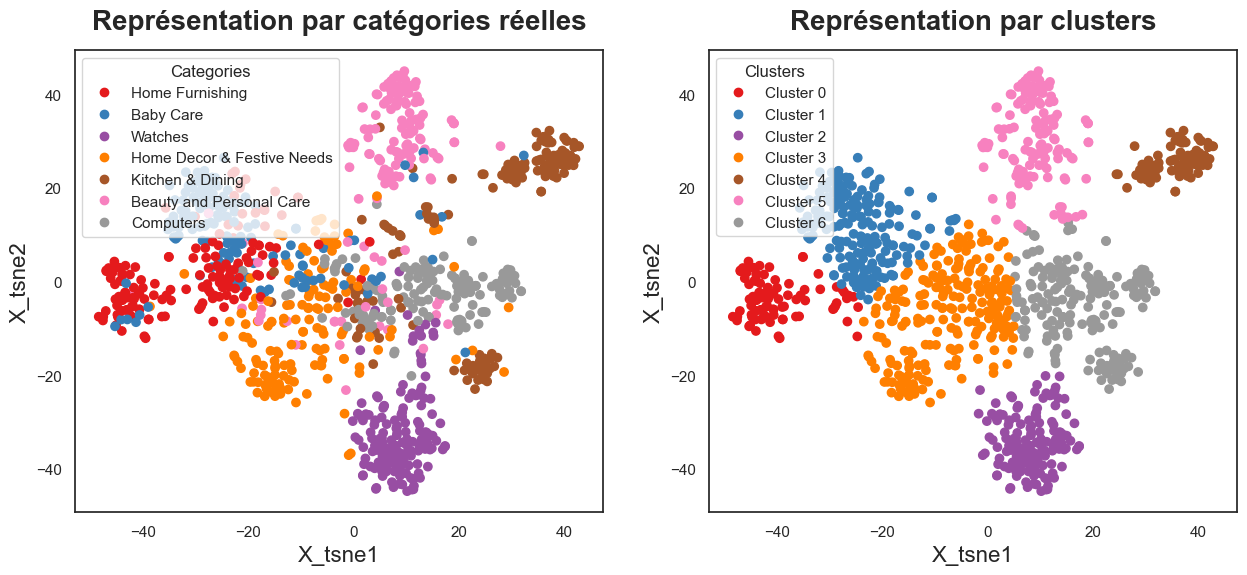

ARI :  0.49


In [43]:
TSNE_visu_fct(
    X_tsne,
    cat_labels,
    cls_labels,
    categories,
    ARI,
    legend_loc="upper left",
    show_ticks=True,
    legend=True,
)

## Matrice de confusion

In [44]:
conf_mat = confusion_matrix(cat_labels, cls_labels)
print(conf_mat)

[[ 78  64   0   8   0   0   0]
 [  7 112   0  22   1   5   3]
 [  0   0 134   2   0   0  14]
 [  3   8   3 126   0   1   9]
 [  0   0   0  20  78  15  37]
 [  1   3   1  16   1 118  10]
 [  0   1   1  29   0   1 118]]


On voit que les colonnes de la matrice de confusion ne sont pas ordonnées. On va définir une fonction de sorte à ce que les correspondances entre les vrais catégories et celles prédites se retrouvent sur la diagonale

In [45]:
print(classification_report(cat_labels, cls_labels))

              precision    recall  f1-score   support

           0       0.88      0.52      0.65       150
           1       0.60      0.75      0.66       150
           2       0.96      0.89      0.93       150
           3       0.57      0.84      0.68       150
           4       0.97      0.52      0.68       150
           5       0.84      0.79      0.81       150
           6       0.62      0.79      0.69       150

    accuracy                           0.73      1050
   macro avg       0.78      0.73      0.73      1050
weighted avg       0.78      0.73      0.73      1050



<Axes: >

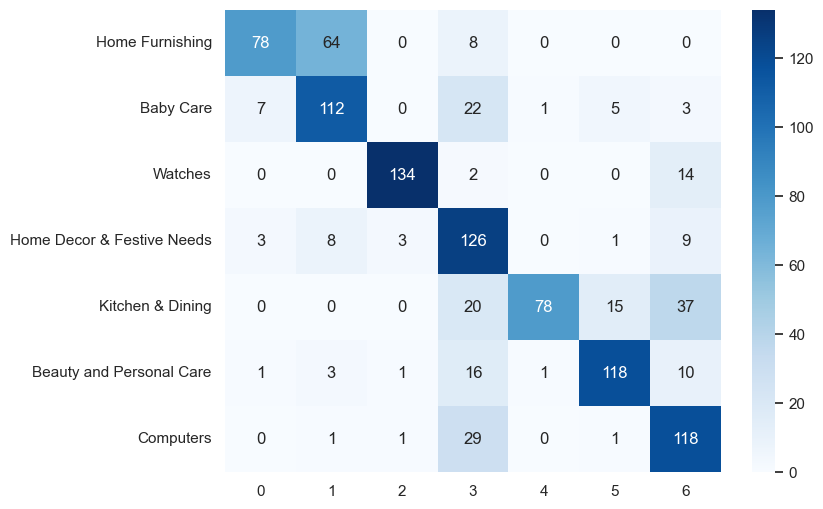

In [46]:
df_cm = pd.DataFrame(conf_mat, index=categories, columns=[i for i in range(n_labels)])
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")

## Classification avec une régression logistique

Entraînons une régression logistique sur les features extraites puis réduites via ACP.

In [49]:
X_train, X_test, y_train, y_test = train_test_split(
    feat_pca, cat_labels, test_size=0.2, random_state=2024
)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

print("Results of the Logistic Regression :")
print("Accuracy on training set : %.3f" % logreg.score(X_train, y_train))
print("Accuracy on validation set : %.3f" % logreg.score(X_test, y_test))

Results of the Logistic Regression :
Accuracy on training set : 1.000
Accuracy on validation set : 0.843


On voit que le modèle overfit.